# Import des librairies

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.inspection import partial_dependence, plot_partial_dependence
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve,
    fbeta_score,
    make_scorer
)





## Delete Warnings

In [142]:
import warnings
warnings.filterwarnings("ignore")

# Preprocessing

##  On reutilise les fonctions definies lors de la premiere partie

In [151]:
sns.set_style('darkgrid')
plt.rc('figure', figsize=[12, 9])
scaler = StandardScaler()
nbr_columns = ['nbrMotInsulte', 'nbrMot', 'nbrMotAllong', 'nbrMotMAJ', 'nbrExclMark', 'nbrQuestMark']
comment_columns = ['message_count', 'thread_count', 'discussion_count']
auth_columns = ['distinct_authors_count', 'authors_3channels_count', 'liked_authors_count']
mean_columns = ['nbrMotMoyenne', 'nbrMotInsulteMoyenne', 'nbrMotAllongMoyenne',
                'nbrMotMAJMoyenne', 'nbrExclMarkMoyenne', 'nbrQuestMarkMoyenne']
num_columns = nbr_columns + comment_columns + auth_columns + ['subscriberCount', 'viewCount']
cat_columns = ['categorie_new', 'categ_inst']
 
# outputs the following list: [X_train, y_train, X_test, y_test]
def create_dataset(plot=False, log=False):
    df = load_dataset()
    if log:
        df = modify_num_data(df, plot)
    if plot:
        describe_cat_data(df)
    df = one_hot_encoding(df)
    if plot:
        correlation_matrix(df)
    df2 = df.sample(frac=0.8, random_state=123)  # must set a seed value in random_state option
    test = df.drop(df2.index, axis=0)
    train = remove_outliers(df)
    if plot:
        find_outliers(df, train)
        describe_num_data(train)
    X_train, y_train = data_and_label(train)
    X_train = normalize(X_train)
    X_test, y_test = data_and_label(test)
    X_test = normalize(X_test, False)
    print()
    print('dataset created')
    print()
    return [X_train, y_train, X_test, y_test]
 
def load_dataset():
    df = pd.read_csv('challenge_youtube_toxic.csv', encoding ='unicode_escape', sep=';', decimal=',')
    # channel name does not seem relevant and will create a lot of dimensions with the one hot encoding
    #TODO: maybe the combined variables are useless
    df = df.drop(['channel_name', 'video_id', 'video_id_court', 'channel_id', 'Unnamed: 27'], axis=1)
    return df
 
def describe_cat_data(df):
    mv = 'some' if df.isnull().values.any() else 'no'
    msg = 'We have ' + str(len(num_columns)) + ' numerical features and ' + str(len(cat_columns)) + \
          ' categorical features for ' + str(len(df.index)) + ' samples.\nThere are ' + mv + ' missing values in this dataset.\n'
    for c in cat_columns:
        plot_scatter(df, c)
        plot_categorical(df, c)
def describe_num_data(df):
    for c in num_columns:
        if c != 'nbrMotInsulte':
            plot_scatter(df, c)
        plot_hist(df, c)
def plot_scatter(df, feature):
    plt.figure()
    plt.title('Plot of number of insulting words by ' + feature)
    plt.scatter(df[feature], df['nbrMotInsulte'])
    plt.show()
def plot_hist(df, feature):
    plt.figure()
    plt.title('Plot of histogram of ' + feature)
    df[feature].hist()
    plt.show()
def plot_categorical(df, feature):
    counts = df[feature].value_counts(normalize=True)
    plt.figure()
    plt.title('Plot of the percentage of samples per distinct value of ' + feature)
    plt.bar(counts.index, counts, align='center', alpha=0.5)
    plt.xticks(counts.index, counts.index)
    plt.show()
def modify_num_data(df, plot):
    cols = nbr_columns + comment_columns + auth_columns
    df[cols] = df[cols].apply(lambda x: np.log(x+1))
    if plot:
        describe_num_data(df)
    return df
 
def find_outliers(df, df2):
    for c in num_columns:
        boxplot(df, df2, c)
def boxplot(df, df2, feature):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Boxplots of ' + feature + ' for Youtube comments, with and without outliers')
    sns.boxplot(ax=ax1, data=df[feature], fliersize=10)  # fliersize is the size used to indicate the outliers
    sns.boxplot(ax=ax2, data=df2[feature], fliersize=10)
    plt.show()
def remove_outliers(df, log=False):
    for c in nbr_columns:
        if c != 'nbrMot':
            df = df[df[c] <= 2000]
            df = df[df[c] <= 30 * df['message_count']]
        else:
            df = df[df[c] <= 400000]
            df = df[df[c] <= 1000*df['message_count']]
    '''# for the number of words or messages, we just leave out the very isolated ones
    df = df[df['nbrMot'] <= 400000]
    df = df[df['message_count'] <= 8000]
    df = df[df['distinct_authors_count'] <= 7500]
    df = df[df['subscriberCount'] <= 400000]'''
    return df
 
def one_hot_encoding(df):
    one_hot = pd.get_dummies(df[cat_columns])
    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(cat_columns, axis=1)
    return df
 
def correlation_matrix(df):
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    plt.figure()
    plt.title('Correlation matrix for Youtube comments')
    sns.heatmap(corr, mask=mask, cmap=cmap)
    plt.show()
def data_and_label(df):
    y = df['nbrMotInsulte']
    y = y.to_numpy()
    X = df.drop(['nbrMotInsulte'], axis=1)
    return [X, y]
 
def normalize(data, train=True):
    if train:
        scaler.fit(data)
    return pd.DataFrame(scaler.transform(data), columns=data.columns)
 
X_train, y_train, X_test, y_test = create_dataset()


dataset created



# Indice de Toxicite

Nous allons utilise le  Mean encoding pour les données catégorielles (il  donne de meilleurs résultats que one hot encoding)

In [152]:
def mean_encoding(df_train, df_test):
    for name_categorical_column in df_train.dtypes[df_train.dtypes=='object'].index.tolist():
        Mean_encoded_subject = df_train.groupby([name_categorical_column])['Toxicity_index'].mean().to_dict() 
        df_train[name_categorical_column] =  df_train[name_categorical_column].map(Mean_encoded_subject)
        df_test[name_categorical_column] =  df_test[name_categorical_column].map(Mean_encoded_subject)
    return df_train, df_test

Nous allons utilise une fonction de scikit-learn afin de determiner quelles ont ete les features les plus preponderantes dans la regression du nombre de mots insultants d`une video donnee et un certain poids

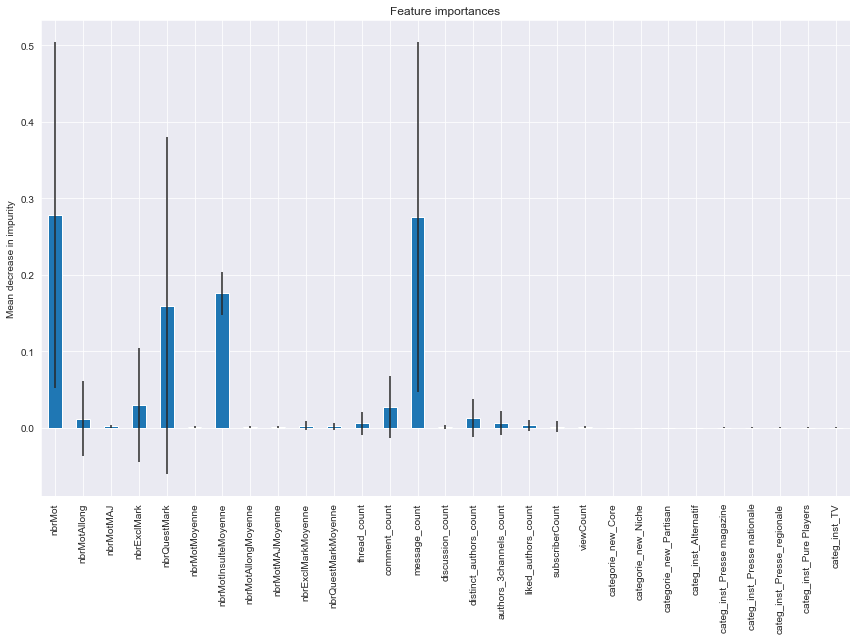

In [153]:

def important_features():
    feature_names = [X_train.columns[i] for i in range(X_train.shape[1])]
    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train,y_train)
    importances = rfr.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
important_features()

 Maintenant que l'on a repérer les features pertinentes à exploiter, determinons un moyen de calculer
 La toxicité d'une video donnée en faisant simplement la somme et la pondération de ces features

In [169]:
def create_toxicity_dataset(df):
    
    def create_toxicity_index(df):
        return(0.28*video[0] + 0.116*video[4] + 0.095 *video[6] + 0.195*video[13])
    df['Toxicity_index'] = df.apply(lambda x: create_toxicity_index(x), axis=1)
    df = df.drop(['nbrMotInsulte','channel_name'],1)
    return df

On implemente une fonction qui nous permettra d'evaluer les differents classifieurs que nous allons entrainer 

In [170]:
def classification_results(classifier, x_test, y_test, beta = 1):
    y_pred_test = classifier.predict(x_test)
    report = classification_report(y_true=y_test, y_pred=y_pred_test)
    matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
    print("Test Set:")
    print(report)
    print('F-{} score is : {}'.format(beta,fbeta_score(y_test, y_pred_test,beta)))
    df_cm = pd.DataFrame(
        matrix, index=[i for i in "01"], columns=[i for i in "01"]
    )
    plt.figure(figsize=(4, 4))
    plt.xlabel("Real class")
    plt.ylabel("Predicted class")
    ax = sns.heatmap(df_cm, annot=True, color="pink")
    ax.set(xlabel="real class", ylabel="predicted class")

### Logistic Regression

Test Set:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10863
           1       0.00      0.00      0.00       663

    accuracy                           0.94     11526
   macro avg       0.47      0.50      0.49     11526
weighted avg       0.89      0.94      0.91     11526

F-1 score is : 0.0


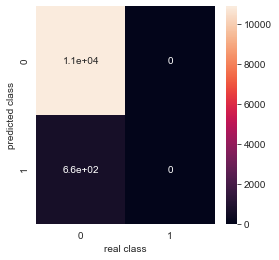

In [171]:
df_train, df_test = train_test_split(df)
df_train, df_test = mean_encoding(df_train, df_test)
model = LogisticRegression().fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
classification_results(model, df_test.iloc[:,:-1],df_test.iloc[:,-1])

Le score F1 peut être interprété comme une moyenne pondérée de precision and recall, où un score F1 atteint sa meilleure valeur à 1 et son pire score à 0. 

La regression logistique ne fut pas pertinente pour notre cas etant donne que le f1 score est egale a 0.

### KNN Classifier


Test Set:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     10892
           1       0.66      0.08      0.15       634

    accuracy                           0.95     11526
   macro avg       0.80      0.54      0.56     11526
weighted avg       0.93      0.95      0.93     11526

F-1 score is : 0.1458625525946704


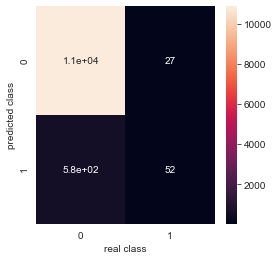

In [172]:
df_train, df_test = train_test_split(df)
df_train, df_test = mean_encoding(df_train, df_test)
model = KNeighborsClassifier().fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
classification_results(model, df_test.iloc[:,:-1],df_test.iloc[:,-1])

### LGBM Classifier

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10861
           1       0.97      0.92      0.95       665

    accuracy                           0.99     11526
   macro avg       0.98      0.96      0.97     11526
weighted avg       0.99      0.99      0.99     11526

F-1 score is : 0.9450889404485692


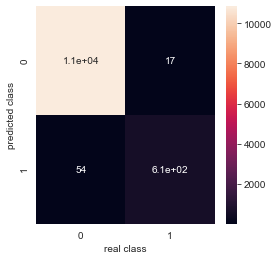

In [173]:
df_train, df_test = train_test_split(df)
df_train, df_test = mean_encoding(df_train, df_test)
model = LGBMClassifier().fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
classification_results(model, df_test.iloc[:,:-1],df_test.iloc[:,-1])

Ce classifier donne de tres bons resultats ( f1 score de 0.951)

### XGBoost Classifier

[12:35:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10875
           1       0.99      0.93      0.96       651

    accuracy                           1.00     11526
   macro avg       0.99      0.97      0.98     11526
weighted avg       1.00      1.00      1.00     11526

F-1 score is : 0.9596837944664031


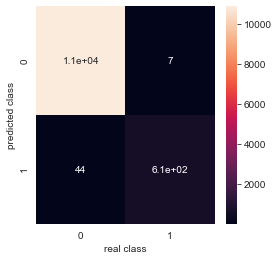

In [174]:
df_train, df_test = train_test_split(df)
df_train, df_test = mean_encoding(df_train, df_test)
model = XGBClassifier().fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
classification_results(model, df_test.iloc[:,:-1],df_test.iloc[:,-1])

Avec le XGBoost Classifier nous avons les meilleurs resultats avec un score f1= 0.953

### Random Forest Classifier

Test Set:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10861
           1       0.99      0.65      0.79       665

    accuracy                           0.98     11526
   macro avg       0.99      0.83      0.89     11526
weighted avg       0.98      0.98      0.98     11526

F-1 score is : 0.7887579329102449


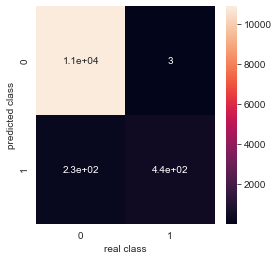

In [175]:
df_train, df_test = train_test_split(df)
df_train, df_test = mean_encoding(df_train, df_test)
model = RandomForestClassifier().fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
classification_results(model, df_test.iloc[:,:-1],df_test.iloc[:,-1])

#### Au vu des resultats , le XGBoost et le LGBM somt les classifier les plus optimises pour notre indice de toxicite

# Etudions la dependance partielle de la toxicite et le nombre moyen d

[12:36:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


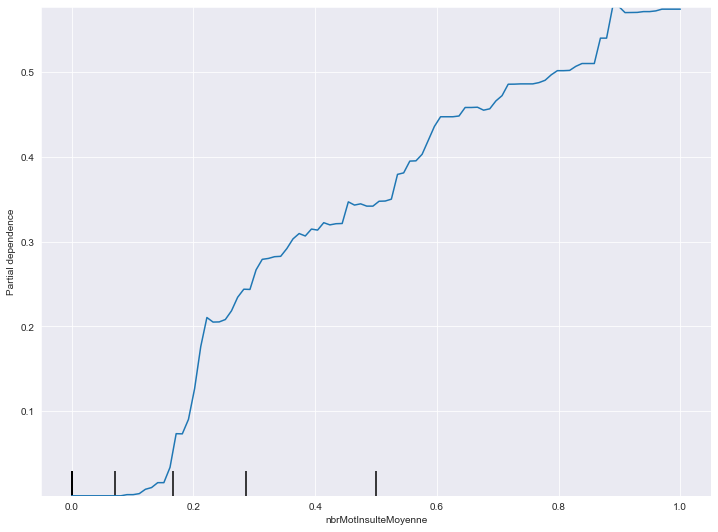

In [177]:
model = XGBClassifier().fit(df_train[['nbrMotInsulteMoyenne','nbrMotMoyenne','nbrMot','categorie_new',
    'thread_count','comment_count', 'nbrExclMarkMoyenne']],df_train['Toxicity_index'])
plot_partial_dependence(model, df_test[['nbrMotInsulteMoyenne','nbrMotMoyenne','nbrMot','categorie_new',
    'thread_count','comment_count', 'nbrExclMarkMoyenne']], ['nbrMotInsulteMoyenne'])
plt.show()

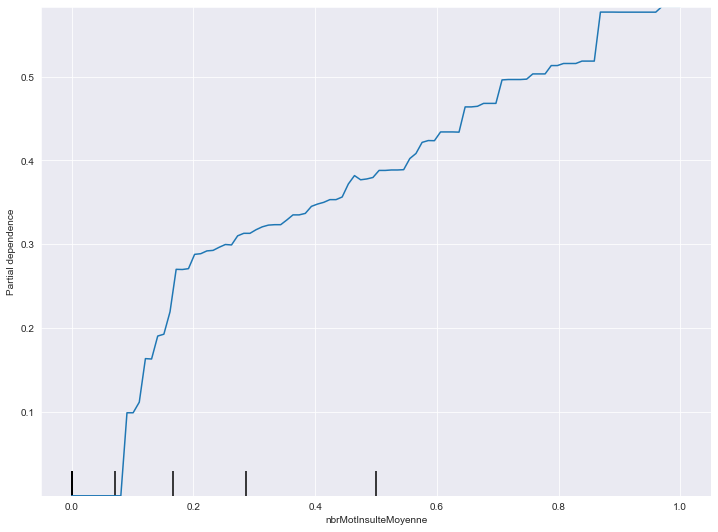

In [179]:
model2 = LGBMClassifier().fit(df_train[['nbrMotInsulteMoyenne','nbrMotMoyenne','nbrMot','categorie_new',
    'thread_count','comment_count', 'nbrExclMarkMoyenne']],df_train['Toxicity_index'])
plot_partial_dependence(model2, df_test[['nbrMotInsulteMoyenne','nbrMotMoyenne','nbrMot','categorie_new',
    'thread_count','comment_count', 'nbrExclMarkMoyenne']], ['nbrMotInsulteMoyenne'])
plt.show()

On peut remarquer que plus le nombre moyen d'insultes augmente, plus la probabilité qu'une vidéo soit toxique augmente. 